<a href="https://colab.research.google.com/github/bhumiii2114/ClusteringAnalysis/blob/main/Clustering_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


In [ ]:
# Load Iris dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target
X.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [ ]:
# Preprocessing steps
def no_processing(X):
    return X.copy()

def normalize(X):
    return MinMaxScaler().fit_transform(X)

def transform_log(X):
    return FunctionTransformer(np.log1p).fit_transform(X)

def apply_pca(X, n_components=2):
    return PCA(n_components=n_components).fit_transform(X)

# Combined Preprocessing
def transform_normalize(X):
    return normalize(transform_log(X))

def transform_normalize_pca(X):
    return apply_pca(transform_normalize(X))


In [ ]:
# Evaluation function
def evaluate_clustering(X, labels):
    try:
        silhouette = silhouette_score(X, labels)
        ch = calinski_harabasz_score(X, labels)
        db = davies_bouldin_score(X, labels)
        return silhouette, ch, db
    except:
        return None, None, None


In [ ]:
preprocess_methods = {
    'No Processing': no_processing,
    'Normalization': normalize,
    'Log Transform': transform_log,
    'PCA': lambda X: apply_pca(X),
    'T+N': transform_normalize,
    'T+N+PCA': transform_normalize_pca
}

cluster_range = [3, 4, 5]

# Store results
results = {
    'KMeans': [],
    'Agglomerative': [],
    'MeanShift': []
}

# KMeans & Agglomerative
for name, func in preprocess_methods.items():
    data = func(X)
    for k in cluster_range:
        km = KMeans(n_clusters=k, random_state=0)
        ag = AgglomerativeClustering(n_clusters=k)

        km_labels = km.fit_predict(data)
        ag_labels = ag.fit_predict(data)

        km_scores = evaluate_clustering(data, km_labels)
        ag_scores = evaluate_clustering(data, ag_labels)

        results['KMeans'].append((name, k, *km_scores))
        results['Agglomerative'].append((name, k, *ag_scores))

# MeanShift (no need to vary k)-Because MeanShift is a density-based clustering algorithm that: Automatically estimates the number of clusters based on data distribution.
for name, func in preprocess_methods.items():
    data = func(X)
    try:
        bandwidth = estimate_bandwidth(data, quantile=0.2)
        if bandwidth <= 0:
            raise Exception("Bad bandwidth")
        ms = MeanShift(bandwidth=bandwidth)
        ms_labels = ms.fit_predict(data)
        ms_scores = evaluate_clustering(data, ms_labels)
        n_clusters = len(np.unique(ms_labels))
        results['MeanShift'].append((name, n_clusters, *ms_scores))
    except:
        results['MeanShift'].append((name, n_clusters, None, None, None))


In [ ]:
# Convert to DataFrame
def format_results(algo_name):
    df = pd.DataFrame(results[algo_name], columns=['Preprocessing', 'Clusters', 'Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin'])
    return df

df_kmeans = format_results('KMeans')
df_agglom = format_results('Agglomerative')
df_meanshift = format_results('MeanShift')

# Display
df_kmeans.head(10)

,Preprocessing,Clusters,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,No Processing,3,0.551192,561.593732,0.666039
1,No Processing,4,0.498051,530.765808,0.780307
2,No Processing,5,0.460950,459.451470,0.915314
3,Normalization,3,0.482929,351.295064,0.786733
4,Normalization,4,0.445065,314.472999,0.900449
5,Normalization,5,0.436406,269.942893,0.931870
6,Log Transform,3,0.571576,974.176228,0.628271
7,Log Transform,4,0.502329,839.178796,0.773787
8,Log Transform,5,0.471326,707.238974,0.884952
9,PCA,3,0.597676,693.708433,0.564816


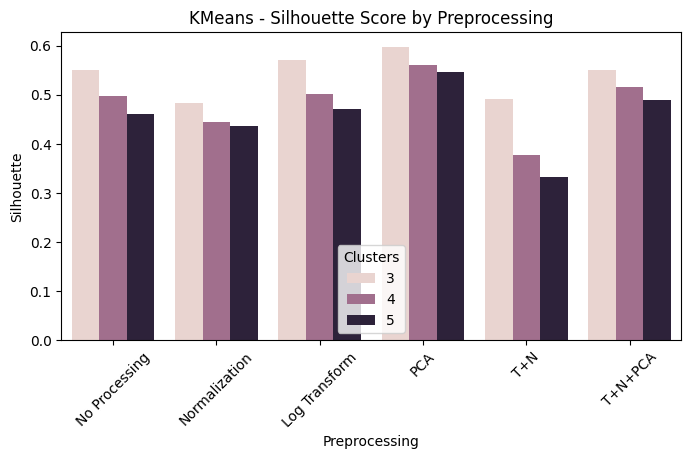

In [ ]:
# Plot Silhouette Score for KMeans
plt.figure(figsize=(8,4))
sns.barplot(data=df_kmeans, x='Preprocessing', y='Silhouette', hue='Clusters')
plt.title("KMeans - Silhouette Score by Preprocessing")
plt.xticks(rotation=45)
plt.show()

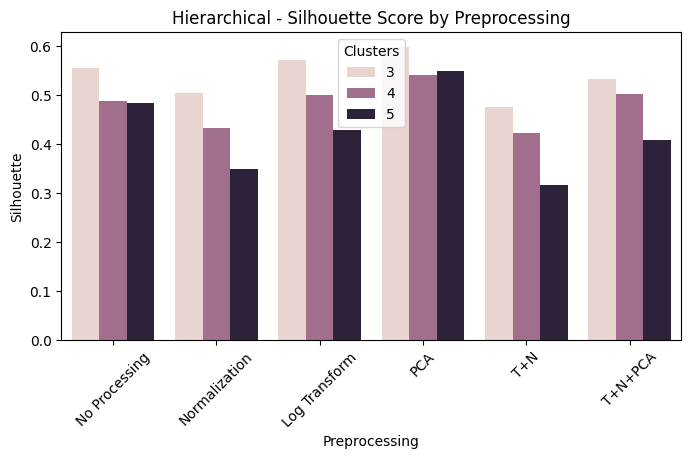

In [ ]:
# Plot Silhouette Score for Agglomerative/Hierarchical
plt.figure(figsize=(8,4))
sns.barplot(data=df_agglom, x='Preprocessing', y='Silhouette', hue='Clusters')
plt.title("Hierarchical - Silhouette Score by Preprocessing")
plt.xticks(rotation=45)
plt.show()

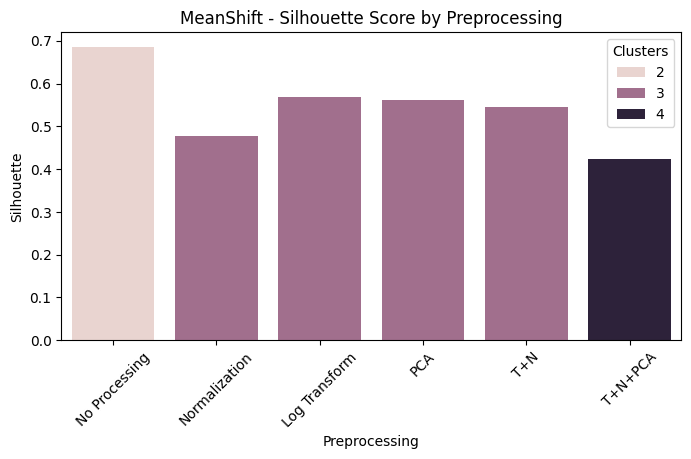

In [ ]:
# Plot Silhouette Score for MeanShift
plt.figure(figsize=(8,4))
sns.barplot(data=df_meanshift, x='Preprocessing', y='Silhouette', hue='Clusters')
plt.title("MeanShift - Silhouette Score by Preprocessing")
plt.xticks(rotation=45)
plt.show()

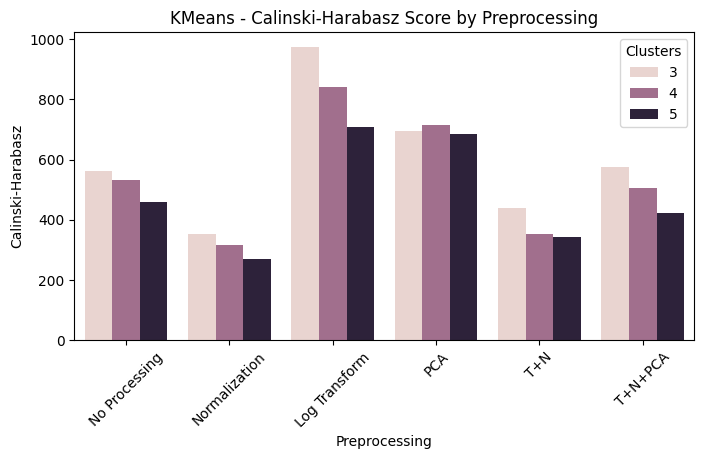

In [ ]:
# Plot Silhouette Score for KMeans
plt.figure(figsize=(8,4))
sns.barplot(data=df_kmeans, x='Preprocessing', y='Calinski-Harabasz', hue='Clusters')
plt.title("KMeans - Calinski-Harabasz Score by Preprocessing")
plt.xticks(rotation=45)
plt.show()

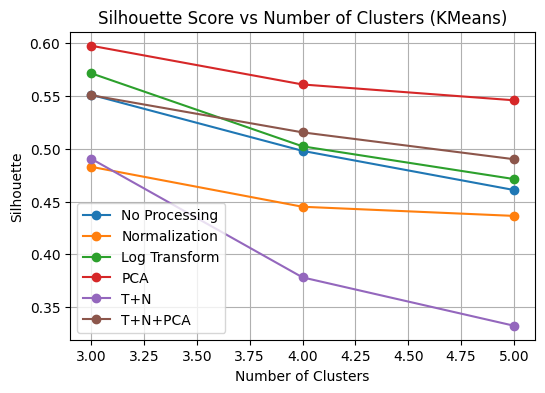

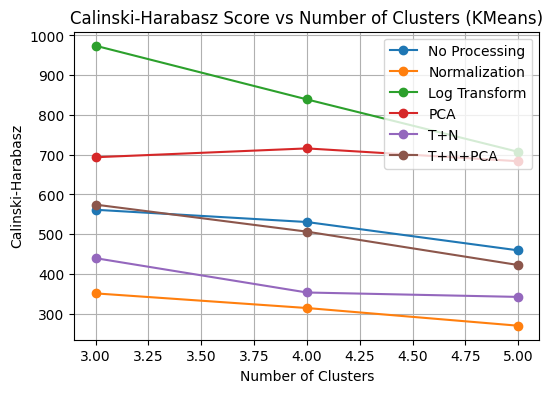

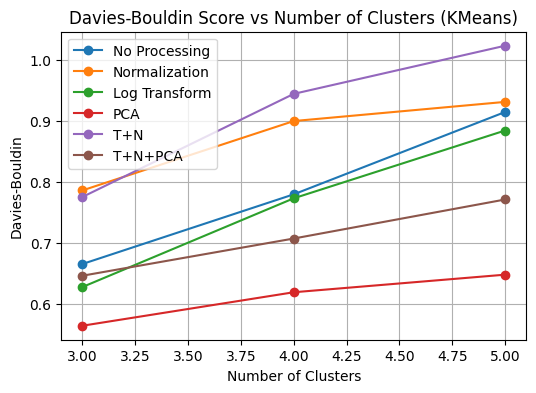

In [ ]:
metrics = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Preprocessings available in your results
preprocessings = df_kmeans['Preprocessing'].unique()

# Create separate plots for each metric
for metric, color in zip(metrics, colors):
    plt.figure(figsize=(6, 4))

    for prep in preprocessings:
        sub_df = df_kmeans[df_kmeans['Preprocessing'] == prep]
        plt.plot(sub_df['Clusters'], sub_df[metric], label=prep, marker='o')

    plt.title(f"{metric} Score vs Number of Clusters (KMeans)")
    plt.xlabel("Number of Clusters")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()